In [1]:
import pandas as pd
from darts import TimeSeries
from darts.models import NHiTSModel
from darts.metrics import mse, rmse, r2_score, mae, smape
from darts.dataprocessing.transformers import Scaler
import torch
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from plotnine import (
    ggplot, aes, geom_line, facet_wrap, labs, theme_bw, theme,
    element_text, element_blank, geom_col, coord_flip
)
import json


torch.set_float32_matmul_precision('medium')


In [2]:
target_columns = [
    'Temperature','Precipitation_accumulated','Humidity', 'Wind_Speed_kmh',
    'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin', 'Wind_Dir_Cos'
]

DATA_FILE_PATH = "data/ground_station_clean.csv"
df = pd.read_csv(DATA_FILE_PATH)

In [3]:
encoders = {
    "cyclic": {
        "past": ["month", "dayofyear", "day", "hour", "minute"],
        "future": ["month", "dayofyear", "day", "hour", "minute"]
    },
    "transformer": Scaler(),
    "datetime_attribute": {
        "past": ["year"],
        "future": ["year"]
    }
}

In [4]:
best_r2 = float('-inf')
best_fold = -1
best_train_scaled = None
best_val_scaled = None
best_scaler = None
best_metrics = None
best_forecasts = None
# Definir parâmetros do modelo

tscv = TimeSeriesSplit(n_splits=7)
fold_metrics = []
for fold, (train_idx, val_idx) in enumerate(tscv.split(df)):

    early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=10, verbose=True)
    pl_trainer_kwargs = {
        "accelerator": "auto",
        "callbacks": [early_stopper],
    }
    train_df_fold, val_df_fold = df.iloc[train_idx], df.iloc[val_idx]
    train_fold = TimeSeries.from_dataframe(train_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')
    val_fold = TimeSeries.from_dataframe(val_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')

    print(f"\n{'='*50}\nFold {fold+1}\n{'='*50}")
    print("\nTreinando o modelo...")
    print(f"Train set: {train_fold.shape[0]} samples")
    print(f"Validation set: {val_fold.shape[0]} samples")
    
    scaler = Scaler()
    # Ajustar o scaler apenas nos dados de treino para evitar data leakage
    scaler = scaler.fit(train_fold)
    # Transformar todas as séries
    train_scaled = scaler.transform(train_fold)
    val_scaled = scaler.transform(val_fold)
    

    model = NHiTSModel(
        model_name=f"model_{fold+1}",
        input_chunk_length=45,
        output_chunk_length=1,
        activation="GELU",
        num_layers=1,
        num_blocks=4,
        num_stacks=3,
        layer_widths=243,
        n_epochs=100,
        batch_size=104,
        dropout=0.1300946376042601,
        add_encoders=encoders,
        pl_trainer_kwargs=pl_trainer_kwargs,
        loss_fn=torch.nn.HuberLoss(),
        optimizer_cls=torch.optim.AdamW,
        lr_scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
        lr_scheduler_kwargs={"mode": "min", "factor": 0.3, "patience": 5, "min_lr": 1e-7},
        save_checkpoints=True,
        show_warnings=True,
        force_reset=True,
        optimizer_kwargs={"lr": 0.00011494227662736073, "weight_decay": 8.444384638688174e-05}
    )
    model.fit(
        series=train_scaled,
        val_series=val_scaled,
        dataloader_kwargs={"num_workers": 11},
        verbose=False,
    )
    
    model.load_from_checkpoint(f"/home/eduardo/Documentos/Water-Cycle-Neural-Network/darts_logs/model_{fold+1}/", best=True)

    forecasts = model.historical_forecasts(
        val_scaled,
        forecast_horizon=1,
        stride=1,
        retrain=False,
        verbose=False,
        last_points_only=True,
    ) 

    forecasts_t = scaler.inverse_transform(forecasts)
    s = scaler.inverse_transform(val_scaled)
    metrics = {}
    print("Iniciando a verificação das séries temporais para constância...")
    try:
        for target in target_columns:
            metrics[target] = {
                'MSE': mse(s[target], forecasts_t[target]),
                'RMSE': rmse(s[target], forecasts_t[target]),
                'MAE': mae(s[target], forecasts_t[target]),
                'R2': r2_score(s[target], forecasts_t[target]),
                'SMAPE': smape(s[target], forecasts_t[target]),
            }
        metrics_df = pd.DataFrame(metrics).T
        print("\nMétricas de performance:")
        print(metrics_df)
    except Exception as e:
        print(e)

    r2_geral = r2_score(s, forecasts_t)
    print(f"O R2 desse fold foi {r2_geral}")
    if best_r2 < r2_geral:
        best_r2 = r2_geral
        best_fold = fold + 1
        best_train_scaled = train_scaled
        best_scaler = scaler
        best_metrics = metrics_df
        best_forecasts = forecasts
        best_val_scaled = val_scaled

print(f"O melhor fold foi {best_fold}")



Fold 1

Treinando o modelo...
Train set: 1043 samples
Validation set: 1038 samples


Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Metric val_loss improved. New best score: 0.062
Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.051
Metric val_loss improved by 0.015 >= min_delta = 0.001. New best score: 0.036
Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.031
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.028
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.026
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.025
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.024
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.023
Metric val_loss improved by 0.

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE        R2  \
Temperature                    38.976704    6.243133    4.691780  0.223046   
Precipitation_accumulated       0.142307    0.377236    0.261155  0.776812   
Humidity                      133.296200   11.545397    9.237831  0.580059   
Wind_Speed_kmh                  0.614669    0.784008    0.617639 -0.439100   
Soil_Moisture              370299.184977  608.522132  425.072431  0.410294   
Soil_Temperature               38.025133    6.166452    4.663007  0.477067   
Wind_Dir_Sin                    0.311032    0.557702    0.446477  0.034659   
Wind_Dir_Cos                    0.378203    0.614982    0.475945 -0.010681   

                                SMAPE  
Temperature                 26.469300  
Precipitation_accumulated    8.042239  
Humidity                    15.045767  
Wind_Speed_kmh              74.975954  
Soil_Mo

Metric val_loss improved. New best score: 16.995
Metric val_loss improved by 0.068 >= min_delta = 0.001. New best score: 16.928
Metric val_loss improved by 0.060 >= min_delta = 0.001. New best score: 16.867
Metric val_loss improved by 0.427 >= min_delta = 0.001. New best score: 16.440
Metric val_loss improved by 0.333 >= min_delta = 0.001. New best score: 16.107
Metric val_loss improved by 0.649 >= min_delta = 0.001. New best score: 15.457
Metric val_loss improved by 0.026 >= min_delta = 0.001. New best score: 15.431
Metric val_loss improved by 0.503 >= min_delta = 0.001. New best score: 14.928
Metric val_loss improved by 0.222 >= min_delta = 0.001. New best score: 14.706
Metric val_loss improved by 0.368 >= min_delta = 0.001. New best score: 14.338
Metric val_loss improved by 0.087 >= min_delta = 0.001. New best score: 14.252
Metric val_loss improved by 0.892 >= min_delta = 0.001. New best score: 13.360
Metric val_loss improved by 0.484 >= min_delta = 0.001. New best score: 12.876
Met

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE          RMSE           MAE  \
Temperature                6.273525e+05    792.055881    675.225334   
Precipitation_accumulated  1.463295e+04    120.966745    102.876927   
Humidity                   3.348581e+04    182.991294     51.332035   
Wind_Speed_kmh             2.160812e+02     14.699700     10.460763   
Soil_Moisture              5.052498e+08  22477.762961  19325.051947   
Soil_Temperature           8.578433e+04    292.889616    249.845043   
Wind_Dir_Sin               1.615631e+03     40.194915     34.601944   
Wind_Dir_Cos               2.565669e+03     50.652429     43.084553   

                                     R2       SMAPE  
Temperature               -18121.091342  155.058041  
Precipitation_accumulated      0.619844   28.932184  
Humidity                    -264.159207   25.474797  
Wind_Speed_kmh              -680.550630  165.801341  


Metric val_loss improved. New best score: 0.016
Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.009
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.007
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.006
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.006. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE  \
Temperature                     5.182908    2.276600    1.747348   
Precipitation_accumulated    1960.456677   44.277045   39.356265   
Humidity                       56.369726    7.507978    6.176658   
Wind_Speed_kmh                  1.454886    1.206186    1.021450   
Soil_Moisture              122791.212374  350.415771  295.395095   
Soil_Temperature               15.019806    3.875539    3.128762   
Wind_Dir_Sin                    0.009718    0.098580    0.078037   
Wind_Dir_Cos                    0.161512    0.401886    0.353579   

                                     R2       SMAPE  
Temperature                2.880267e-02   13.246114  
Precipitation_accumulated -1.762002e+07    8.151025  
Humidity                  -2.256729e+00    6.819317  
Wind_Speed_kmh                     -inf  200.000000  
Soil_Moisture             -

Metric val_loss improved. New best score: 0.005
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.004
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.003
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.002
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.002. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE            R2  \
Temperature                    6.152592    2.480442    1.767265 -1.035435e+01   
Precipitation_accumulated    420.968824   20.517525   17.184019 -1.268117e+04   
Humidity                      33.772810    5.811438    4.589167 -2.406723e+00   
Wind_Speed_kmh                 0.336499    0.580085    0.381327          -inf   
Soil_Moisture              51878.984637  227.769587  182.497170 -5.916431e-01   
Soil_Temperature               5.075098    2.252798    1.498539 -2.307727e+01   
Wind_Dir_Sin                   0.004465    0.066824    0.051732          -inf   
Wind_Dir_Cos                   0.032981    0.181608    0.162301          -inf   

                                SMAPE  
Temperature                 24.522123  
Precipitation_accumulated    3.851807  
Humidity                     5.178596  
Wind_Speed_kmh      

Metric val_loss improved. New best score: 0.009
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.007
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.004
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.004. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
GPU available: 

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE           R2  \
Temperature                    2.691195    1.640486    1.255158    -0.142107   
Precipitation_accumulated   2222.818395   47.146775   32.762168 -7722.032803   
Humidity                      28.298195    5.319605    4.263749     0.379894   
Wind_Speed_kmh                 0.106070    0.325685    0.272592   -49.198687   
Soil_Moisture              48261.757046  219.685587  178.862300    -4.905501   
Soil_Temperature               8.043376    2.836085    2.403977    -3.998558   
Wind_Dir_Sin                   0.049636    0.222792    0.148367     0.154157   
Wind_Dir_Cos                   0.058314    0.241483    0.180997     0.350140   

                                SMAPE  
Temperature                 18.411506  
Precipitation_accumulated    7.703669  
Humidity                     5.057718  
Wind_Speed_kmh             19

Metric val_loss improved. New best score: 0.029
Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.026
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.023
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.021
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.020
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.018
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.017
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.016
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.014
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.013
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.012
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.012. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False,

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE          R2  \
Temperature                     3.000731    1.732262    1.367775    0.684107   
Precipitation_accumulated     266.355197   16.320392   12.438207 -230.885839   
Humidity                       22.584649    4.752331    3.534647    0.800601   
Wind_Speed_kmh                  0.955071    0.977277    0.729587    0.386039   
Soil_Moisture              161304.047045  401.626751  292.792811    0.867791   
Soil_Temperature                7.200306    2.683339    1.971279   -0.432155   
Wind_Dir_Sin                    0.336020    0.579673    0.453527    0.305761   
Wind_Dir_Cos                    0.291586    0.539987    0.432201    0.397468   

                                SMAPE  
Temperature                 38.842711  
Precipitation_accumulated    2.737594  
Humidity                     3.908619  
Wind_Speed_kmh              9

Metric val_loss improved. New best score: 0.022
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.020
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.019
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.018
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.015
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.014
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.013
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.013. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many wor

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE          R2  \
Temperature                    8.287090    2.878731    2.304913    0.691591   
Precipitation_accumulated    258.855484   16.088986   13.046012 -964.651562   
Humidity                      35.865529    5.988784    4.692256    0.759329   
Wind_Speed_kmh                 0.665671    0.815887    0.629999    0.444783   
Soil_Moisture              22233.805063  149.110043  120.975573   -2.727393   
Soil_Temperature               4.347548    2.085077    1.648376    0.608456   
Wind_Dir_Sin                   0.423449    0.650730    0.543194    0.214396   
Wind_Dir_Cos                   0.307759    0.554760    0.463331    0.079483   

                                SMAPE  
Temperature                 23.152212  
Precipitation_accumulated    2.855054  
Humidity                     5.740347  
Wind_Speed_kmh              59.171557 

In [5]:
model.load_from_checkpoint(f"/home/eduardo/Documentos/Water-Cycle-Neural-Network/darts_logs/model_{best_fold}/", best=True)

NHiTSModel(output_chunk_shift=0, num_stacks=3, num_blocks=4, num_layers=1, layer_widths=243, pooling_kernel_sizes=None, n_freq_downsample=None, dropout=0.1300946376042601, activation=GELU, MaxPool1d=True, model_name=model_1, input_chunk_length=45, output_chunk_length=1, n_epochs=100, batch_size=104, add_encoders={'cyclic': {'past': ['month', 'dayofyear', 'day', 'hour', 'minute'], 'future': ['month', 'dayofyear', 'day', 'hour', 'minute']}, 'transformer': Scaler, 'datetime_attribute': {'past': ['year'], 'future': ['year']}}, pl_trainer_kwargs={'accelerator': 'auto', 'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f1f93685be0>]}, loss_fn=HuberLoss(), optimizer_cls=<class 'torch.optim.adamw.AdamW'>, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, lr_scheduler_kwargs={'mode': 'min', 'factor': 0.3, 'patience': 5, 'min_lr': 1e-07}, save_checkpoints=True, show_warnings=True, force_reset=True, optimizer_kwargs={'lr': 0.0001149422766273

In [6]:
s = best_scaler.inverse_transform(best_val_scaled)
forecasts_t = best_scaler.inverse_transform(best_forecasts)
s_df = s.to_dataframe()
s_df = s_df.reset_index()
forecasts_t_df = forecasts_t.to_dataframe()
forecasts_t_df = forecasts_t_df.reset_index()
forecasts_t_df = forecasts_t_df.rename(columns={"time": "Timestamp"})
print(forecasts_t_df.columns)

Index(['Timestamp', 'Temperature', 'Precipitation_accumulated', 'Humidity',
       'Wind_Speed_kmh', 'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin',
       'Wind_Dir_Cos'],
      dtype='object', name='component')


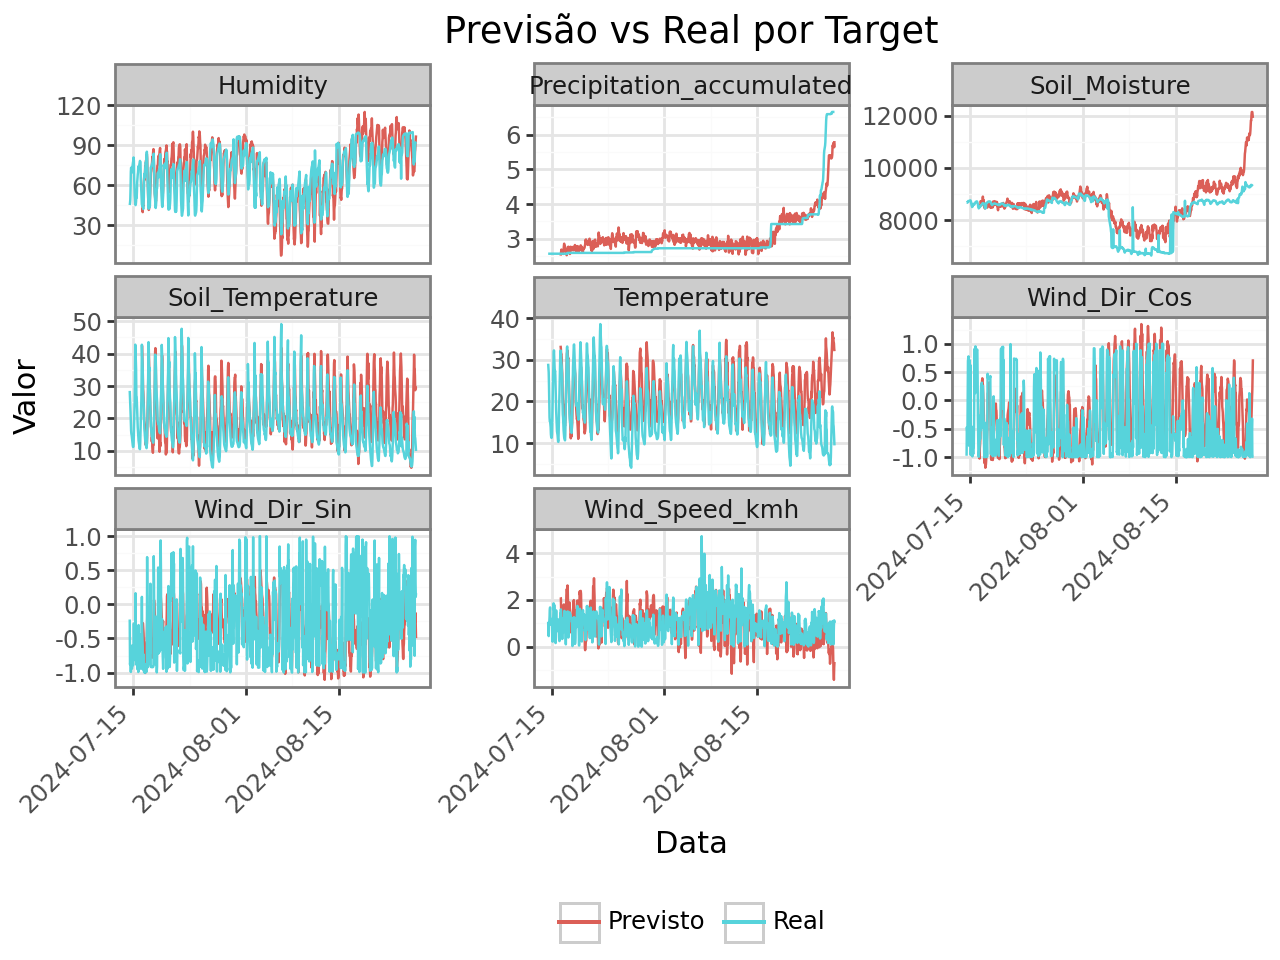

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: previsao_vs_real.png


In [7]:
plot_columns = ['Timestamp'] + target_columns
s_melted = s_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)
s_melted['type'] = 'Real'

forecasts_t_melted = forecasts_t_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)
forecasts_t_melted['type'] = 'Previsto'

# Concatena os DataFrames 'Real' e 'Previsto'
df_combined = pd.concat([s_melted, forecasts_t_melted])

# Opcional: Renomear a coluna de índice para algo mais descritivo, se for data/hora
df_combined = df_combined.rename(columns={'Timestamp': 'Date'})

plot = (
    ggplot(df_combined, aes(x='Date', y='value', color='type'))
    + geom_line()
    + facet_wrap('~ target_column', scales='free_y') # Cria um subplot para cada 'target_column'
    + labs(
        title='Previsão vs Real por Target',
        x='Data',
        y='Valor',
        color='Tipo de Dados' # Legenda para a cor
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1), # Rotaciona os rótulos do eixo x
        legend_position='bottom', # Coloca a legenda na parte inferior
        legend_title=element_blank(), # Remove o título da legenda
    )
)
plot.show()
plot.save('previsao_vs_real.png', width=12, height=10, dpi=300)

In [8]:
pred = model.predict(
    n=24,
    verbose=True
)

pred.t = best_scaler.inverse_transform(pred)
pred_df = pred.to_dataframe()
pred_df = pred_df.reset_index()
pred_df = pred_df.rename(columns={"time": "Timestamp"})

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

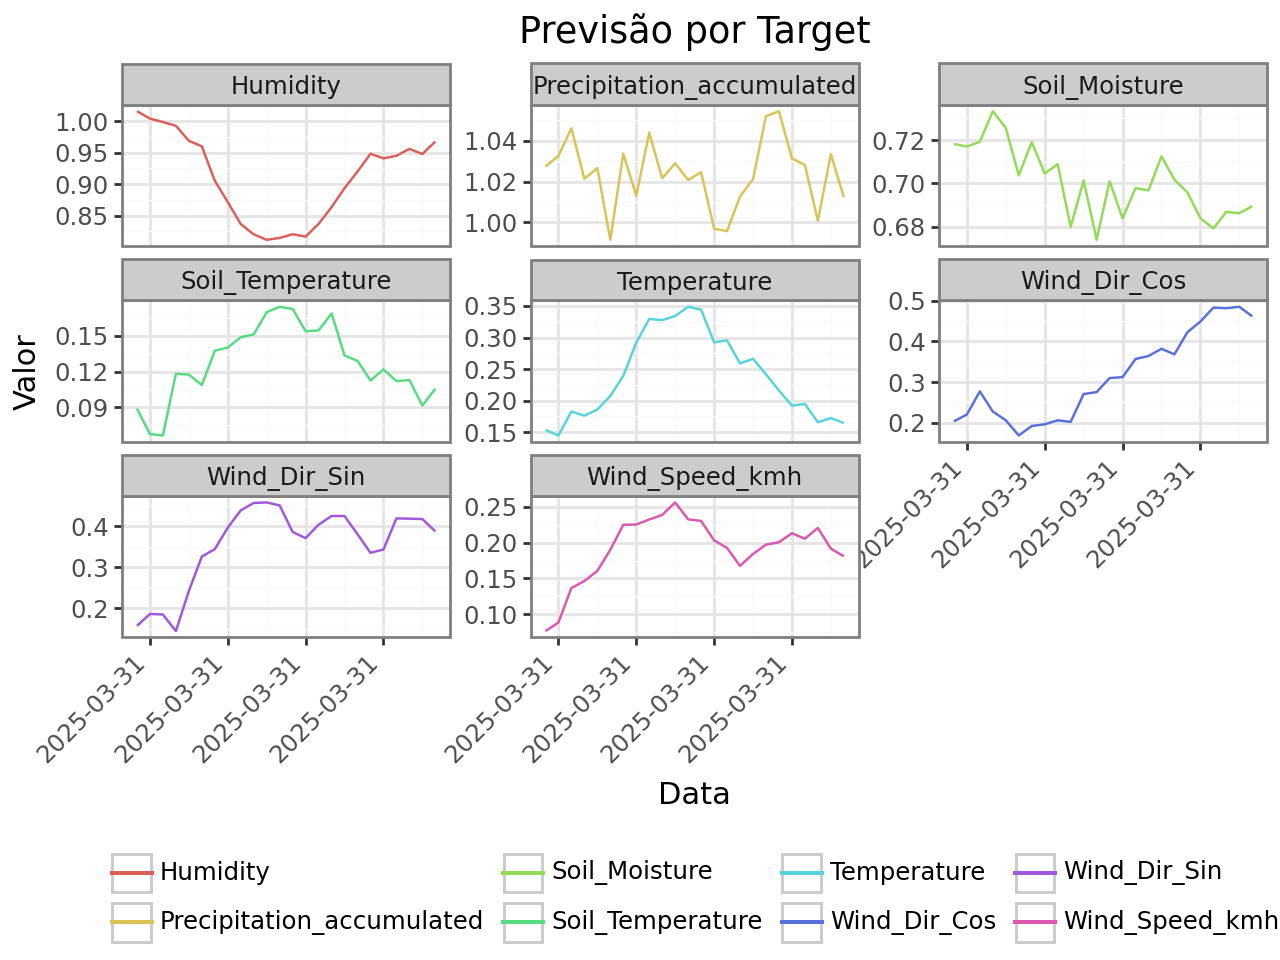

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: previsao_24_horas.png


In [9]:
plot_columns = ['Timestamp'] + target_columns
pred_melted = pred_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)

plot = (
    ggplot(pred_melted, aes(x='Timestamp', y='value', color='target_column'))
    + geom_line()
    + facet_wrap('~ target_column', scales='free_y') # Cria um subplot para cada 'target_column'
    + labs(
        title='Previsão por Target',
        x='Data',
        y='Valor',
        color='Tipo de Dados' # Legenda para a cor
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1), # Rotaciona os rótulos do eixo x
        legend_position='bottom', # Coloca a legenda na parte inferior
        legend_title=element_blank(), # Remove o título da legenda
        
    )
)
plot.show()
plot.save('previsao_24_horas.png', width=12, height=10, dpi=300)

In [10]:
with open('best_metrics.json', 'w') as f:
    json.dump(best_metrics.to_dict(), f, indent=4)